<a href="https://colab.research.google.com/github/rpadmanabhan/probability-I-proj/blob/main/final_turn_in.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Module Installations
!pip install --quiet pyro-ppl==1.7.0
!pip install --quiet h5py
!pip install --quiet anndata
!pip install --quiet scanpy
!pip install --quiet wandb
!pip install --quiet rpy2
!pip install --quiet python-igraph
!pip install --quiet louvain

     |████████████████████████████████| 678 kB 14.6 MB/s 


In [ ]:
# Module Imports
import collections
import functools
from pprint import pprint

import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import tqdm.notebook as tq
import pyro
import anndata
import h5py
import scanpy
import wandb
import seaborn as sns
import torch
import torch.nn.functional as F
import networkx as nx
from sklearn import metrics
from torch.distributions import constraints
from pyro.distributions import *
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm import tqdm

assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(0)




In [ ]:
# Globally set tensors on GPU - Change accordingly
torch.set_default_tensor_type("torch.cuda.DoubleTensor")


# Data download

In [ ]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

#Starvation h5ad data, all nonzero genes included, filtered for 'real cells' from de-multiplexing
download_file('10.22002/D1.1797','.gz')
#CellRanger Starvation h5ad data
download_file('10.22002/D1.1798','.gz')
#Kallisto bus clustered starvation data, h5ad
download_file('10.22002/D1.1796','.gz')
#Human ortholog annotations
download_file('10.22002/D1.1819','.gz')
#Panther annotations
download_file('10.22002/D1.1820','.gz')
#GO Terms
download_file('10.22002/D1.1822','.gz')
#Saved DeSeq2 Results for Fed/Starved (Differentially expressed under starvation --> perturbed genes)
download_file('10.22002/D1.1810','.gz')
#Saved gene modules adata
download_file('10.22002/D1.1813','.gz')
#Gene Markers to plot (for cell atlas) --> Fig 2 heatmap
download_file('10.22002/D1.1809','.gz')

!gunzip *.gz

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/26058 [00:00<?, ?B/s]

  0%|          | 0/45376 [00:00<?, ?B/s]

  0%|          | 0/479630 [00:00<?, ?B/s]

  0%|          | 0/528 [00:00<?, ?B/s]

  0%|          | 0/515 [00:00<?, ?B/s]

  0%|          | 0/227 [00:00<?, ?B/s]

  0%|          | 0/224 [00:00<?, ?B/s]

  0%|          | 0/59338 [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/rnaseq/geuvadis_cleaned.txt.gz ./
!cp /content/drive/MyDrive/rnaseq/samples_to_keep.txt ./

# Keep only samples of European origin
samples_to_keep = []
with open("samples_to_keep.txt", "r") as IN:
    for line in IN:
        samples_to_keep.append(line.strip("\n"))

df = pd.read_csv("geuvadis_cleaned.txt.gz", sep = "\t")
orig_df = df.copy()
df = df.loc[:, df.columns.isin(samples_to_keep)]
data_geuvadis = df.to_numpy()


# Models

> Dirchlet Process Poisson-Lognormal Mixture Model



In [ ]:
class DPPLMClust:
  ''' Dirchlet Process LogNormal-Poissson Mixture Model Clustering
  '''
  def __init__(self, *args, **kwargs):
      '''
      '''
      # mandatory
      self.data = kwargs["data"]
      self.num_clusters = kwargs["num_clusters"]
      self.alpha = kwargs["alpha"]

      # optionals
      self.optim = kwargs.get("optim", Adam({"lr": 0.05}))
      self.niter = kwargs.get("niter", 1500)
      self.loss = kwargs.get("loss", Trace_ELBO())

      # others vars used in this class
      self.losses = []
      self.svi  = None


  # Define the "stick-breaking" function that generates our weights, given our samples of Beta
  def mix_weights(self, beta):
      beta1m_cumprod = (1 - beta).cumprod(-1)
      return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

  def model(self, data):
      with pyro.plate("beta_plate", self.num_clusters - 1):
          beta = pyro.sample("beta", Beta(1, self.alpha))

      with pyro.plate("lambda_plate", self.num_clusters):
          lmbda = pyro.sample("lambda", MultivariateNormal(
              loc = torch.zeros(data.shape[1]), scale_tril = torch.eye(data.shape[1])))
          #lmbda = pyro.sample("lambda", MultivariateNormal(loc = torch.zeros(data.shape[1]), covariance_matrix = torch.eye(data.shape[1])))
      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(self.mix_weights(beta)))
          pyro.sample("obs", Poisson(torch.exp(lmbda[z])).to_event(1), obs = data)

  def guide(self, data):
      # Define priors to sample from
      kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample(
          [self.num_clusters - 1]), constraint=constraints.positive)
      mu = pyro.param('mu', lambda: MultivariateNormal(
          loc = torch.ones(data.shape[1]),
          covariance_matrix = torch.eye(data.shape[1])).sample([self.num_clusters]))
      # Vector of variances for each of the d variables
      theta = pyro.param('theta', lambda: HalfCauchy(torch.ones(data.shape[1])).sample(
          [self.num_clusters]))
      # Lower cholesky factor of a correlation matrix
      #concentration = torch.ones(())  # Implies a uniform distribution over correlation matrices
      L_omega = pyro.param("L_omega", lambda: LKJCholesky(data.shape[1], torch.ones(())).sample([self.num_clusters]), constraint=constraints.lower_cholesky)
      # Lower cholesky factor of the covariance matrix
      L_Omega = pyro.param("L_Omega", lambda: torch.bmm(theta.sqrt().diag_embed(), L_omega), constraint=constraints.lower_cholesky)

      phi = pyro.param('phi', lambda: Dirichlet(
          1/self.num_clusters * torch.ones(self.num_clusters)).sample(
              [data.shape[0]]), constraint=constraints.simplex)

      # Define parameters in the model
      with pyro.plate("beta_plate", self.num_clusters - 1):
          q_beta = pyro.sample("beta", Beta(torch.ones(self.num_clusters - 1), kappa))

      with pyro.plate("lambda_plate", self.num_clusters):
          q_lambda = pyro.sample("lambda", MultivariateNormal(loc = mu, scale_tril = L_Omega))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(phi))


  def train_batch(self, loader):
      pyro.clear_param_store()
      for j in tqdm(range(self.niter)):
          for bx in loader:
              loss = self.svi.step(bx[0].cuda())
              self.losses.append(loss)

  def train(self):
      pyro.clear_param_store()
      for j in tqdm(range(self.niter)):
          loss = self.svi.step(self.data)
          self.losses.append(loss)

  def truncate(self, centers, weights):
      threshold = self.alpha**-1 / 100.
      true_centers = centers[weights > threshold]
      true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
      return true_centers, true_weights

  def var_inference(self):
      self.svi = SVI(self.model, self.guide, self.optim, loss = self.loss)
      self.train()

  def loss_viz(self):
      elbo_plot = plt.figure(figsize=(15, 5))
      elbo_ax = elbo_plot.add_subplot(1, 2, 1)
      elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI")
      elbo_ax.set_ylabel("ELBO")
      elbo_ax.set_xlabel("Iteration Number")
      elbo_ax.plot(np.arange(self.niter), self.losses)

      autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
      autocorr_ax.acorr(np.asarray(self.losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
      autocorr_ax.set_xlim(0, 500)
      autocorr_ax.axhline(0, ls="--", c="k", lw=1)
      autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI")
      autocorr_ax.set_xlabel("Lag")
      autocorr_ax.set_ylabel("Autocorrelation")
      elbo_plot.tight_layout()
      plt.show()

  def cluster_2d_viz(self):
      # We make a point-estimate of our model parameters using the posterior means of mu and phi for the centers and weights
      Bayes_Centers_01, Bayes_Weights_01 = self.truncate(
          torch.exp(pyro.param("mu")).detach(),
          torch.mean(pyro.param("phi").detach(), dim=0))
      plt.figure(figsize=(15, 5))
      plt.subplot(1, 2, 1)
      plt.scatter(self.data[:, 0].cpu(), self.data[:, 1].cpu(), color="blue")
      plt.scatter(Bayes_Centers_01[:, 0].cpu(), Bayes_Centers_01[:, 1].cpu(), color="red")
      plt.legend(["Simulated Data", "Cluster Centers Identified"])
      plt.title("Clustering using DPMM on simulated data.")

> Dirchlet Process Gamma-Poisson Mixture Model


In [ ]:
class DPPMClust:
  ''' Dirchlet Process - Independent Poissson Mixture Model Clustering
  '''
  def __init__(self, *args, **kwargs):
      '''
      '''
      # mandatory
      self.data = kwargs["data"]
      self.num_clusters = kwargs["num_clusters"]
      self.alpha = kwargs["alpha"]

      # optionals
      self.optim = kwargs.get("optim", Adam({"lr": 0.05}))
      self.niter = kwargs.get("niter", 1500)
      self.loss = kwargs.get("loss", Trace_ELBO())

      # others vars used in this class
      self.losses = []
      self.svi  = None


  # Define the "stick-breaking" function that generates our weights, given our samples of Beta
  def mix_weights(self, beta):
      beta1m_cumprod = (1 - beta).cumprod(-1)
      return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

  def model(self, data):
      with pyro.plate("beta_plate", self.num_clusters - 1):
          beta = pyro.sample("beta", Beta(1, self.alpha))

      with pyro.plate("lambda_plate", self.num_clusters):
          lmbda = pyro.sample("lambda", Gamma(torch.ones(data.shape[1]),
                                              torch.ones(data.shape[1])).to_event(1))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(self.mix_weights(beta)))
          pyro.sample("obs", Poisson(lmbda[z]).to_event(1), obs = data)

  def guide(self, data):
      # Define priors to sample from
      kappa = pyro.param('kappa', lambda: Uniform(0, 2).sample(
          [self.num_clusters - 1]), constraint=constraints.positive)
      tau_0 = pyro.param('tau_0', lambda: Uniform(
          2.0 * torch.ones(data.shape[1]),
          6.0 * torch.ones(data.shape[1])).to_event(1).sample([self.num_clusters]),
          constraint=constraints.positive)
      tau_1 = pyro.param('tau_1', lambda: Uniform(
          torch.ones(data.shape[1]),
          3.0 * torch.ones(data.shape[1])).to_event(1).sample([self.num_clusters]),
          constraint=constraints.positive)
      phi = pyro.param('phi', lambda: Dirichlet(
          1/self.num_clusters * torch.ones(self.num_clusters)).sample(
              [data.shape[0]]), constraint=constraints.simplex)

      # Define parameters in the model
      with pyro.plate("beta_plate", self.num_clusters - 1):
          q_beta = pyro.sample("beta", Beta(torch.ones(self.num_clusters - 1), kappa))

      with pyro.plate("lambda_plate", self.num_clusters):
        q_lambda = pyro.sample("lambda", Gamma(tau_0, tau_1).to_event(1))

      with pyro.plate("data", data.shape[0]):
          z = pyro.sample("z", Categorical(phi))

  def train(self):
      pyro.clear_param_store()
      for j in tq.tqdm(range(self.niter)):
          loss = self.svi.step(self.data)
          self.losses.append(loss)

  def truncate(self, centers, weights):
      threshold = self.alpha**-1 / 100.
      true_centers = centers[weights > threshold]
      true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
      return true_centers, true_weights

  def var_inference(self):
      self.svi = SVI(self.model, self.guide, self.optim, loss = self.loss)
      self.train()

  def loss_viz(self):
      elbo_plot = plt.figure(figsize=(15, 5))
      elbo_ax = elbo_plot.add_subplot(1, 2, 1)
      elbo_ax.set_title("ELBO Value vs. Iteration Number for Pyro BBVI")
      elbo_ax.set_ylabel("ELBO")
      elbo_ax.set_xlabel("Iteration Number")
      elbo_ax.plot(np.arange(self.niter), self.losses)

      autocorr_ax = elbo_plot.add_subplot(1, 2, 2)
      autocorr_ax.acorr(np.asarray(self.losses), detrend=lambda x: x - x.mean(), maxlags=750, usevlines=False, marker=',')
      autocorr_ax.set_xlim(0, 500)
      autocorr_ax.axhline(0, ls="--", c="k", lw=1)
      autocorr_ax.set_title("Autocorrelation of ELBO vs. Lag for Pyro BBVI")
      autocorr_ax.set_xlabel("Lag")
      autocorr_ax.set_ylabel("Autocorrelation")
      elbo_plot.tight_layout()
      plt.show()

  def cluster_2d_viz(self):
      # We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
      Bayes_Centers_01, Bayes_Weights_01 = self.truncate(
          pyro.param("tau_0").detach() / pyro.param("tau_1").detach(),
          torch.mean(pyro.param("phi").detach(), dim=0))
      plt.figure(figsize=(15, 5))
      plt.subplot(1, 2, 1)
      plt.scatter(self.data[:, 0].cpu(), self.data[:, 1].cpu(), color="blue")
      plt.scatter(Bayes_Centers_01[:, 0].cpu(), Bayes_Centers_01[:, 1].cpu(), color="red")

In [ ]:
def run_clustering(num_clusters, alpha, model, num_steps, data):
    ''' Init and run the clustering model
    '''
    # Setup optimizer - Using clipped adam for numerical stability
    initial_lr = 0.001
    gamma = 0.1  # final learning rate will be gamma * initial_lr
    lrd = gamma ** (1 / num_steps)
    optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})
    if model.lower() == "poissonlognormal":
        clust_model = DPPLMClust(data = torch.tensor(data), num_clusters = num_clusters, alpha = alpha, niter = num_steps, optim = optim)
    elif model.lower() == "gammapoisson":
        clust_model = DPPMClust(data = torch.tensor(data), num_clusters = num_clusters, alpha = alpha, niter = num_steps, optim = optim)
    else:
        raise Exception("Unknown Model")

    clust_model.var_inference()
    clust_model.loss_viz()
    clust_model.cluster_2d_viz()

    return clust_model

# Simulation Data

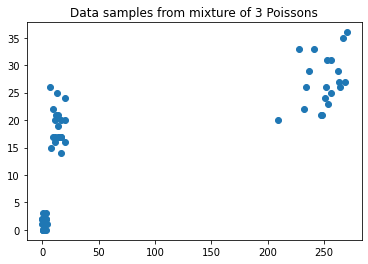

In [ ]:
# Simulation data - Multivariate Poisson-Lognormal of dimension 2 with 3 clusters
theta1 = MultivariateNormal(loc = 3 * torch.ones(2), covariance_matrix = torch.eye(2)).sample([1])
theta2 = MultivariateNormal(loc = torch.zeros(2), covariance_matrix = torch.eye(2)).sample([1])
theta3 = MultivariateNormal(loc = 4 * torch.ones(2), covariance_matrix = torch.eye(2)).sample([1])
num_points_each = 20
test_data = torch.cat(
    (Poisson(torch.exp(theta1)).to_event(1).sample([num_points_each]),
     Poisson(torch.exp(theta2)).to_event(1).sample([num_points_each]),
     Poisson(torch.exp(theta3)).to_event(1).sample([num_points_each])), axis = 0
)

test_data = test_data.reshape(num_points_each * 3, 2)
plt.scatter(test_data[:, 0].cpu(), test_data[:, 1].cpu())
#plt.scatter(test_data|[:, 0], test_data[:, 1])
plt.title("Data samples from mixture of 3 Poissons")
plt.show()

100%|██████████| 5000/5000 [01:07<00:00, 74.04it/s]


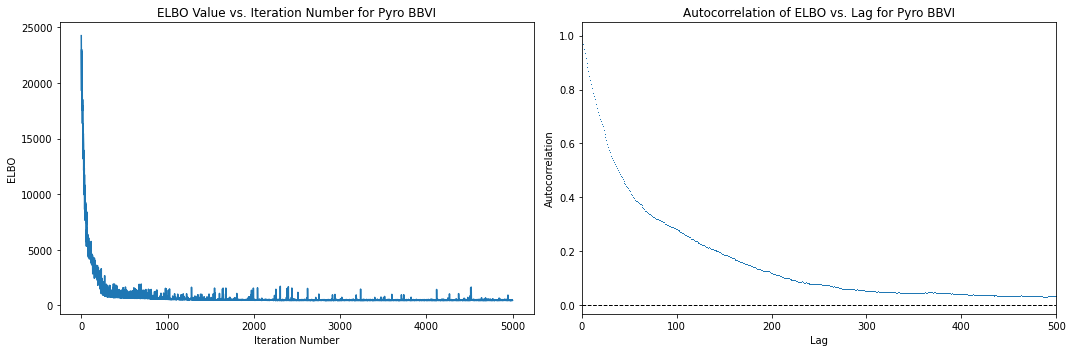

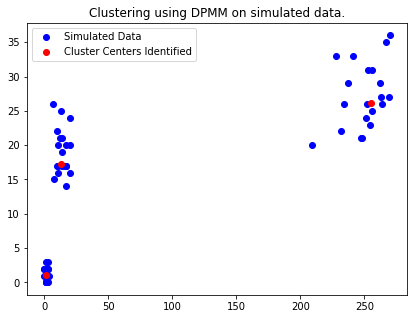

In [ ]:
# Try on test data
alpha = 10.0
dpplm_clust = DPPLMClust(data = test_data, num_clusters = 3, alpha = alpha, niter = 5000)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

## Choose number of clusters = 3

Text(0.5, 1.0, 'Heatmap - Cluster Membership Probabilities')

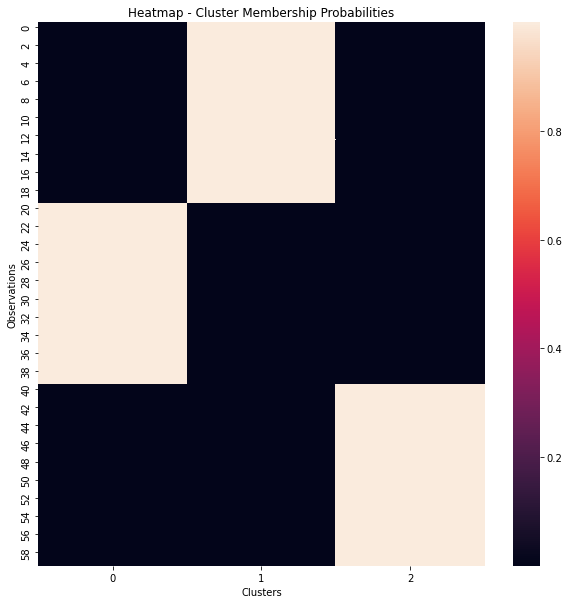

In [ ]:
# Cluster memberships
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (10, 10))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")

Text(0.5, 1.0, 'Heatmap - Probability that 2 observations are in the same cluster')

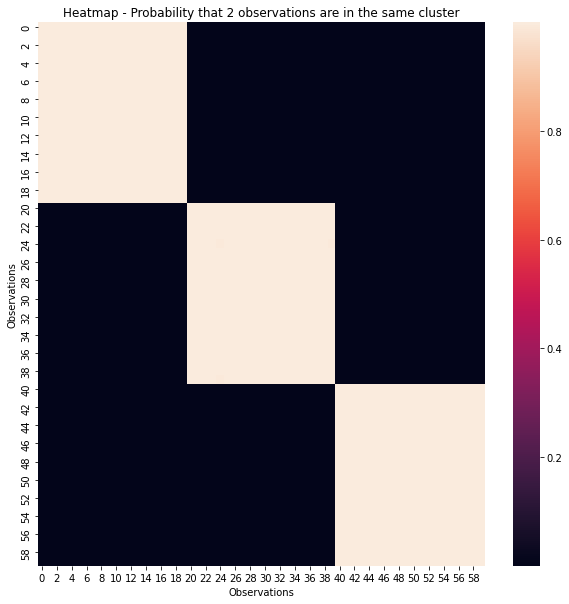

In [ ]:
# 2 observations are in the same cluster - visualize clustering of observations
pairwise = probs @ probs.T
fig, axs = plt.subplots(figsize = (10, 10))
sns.heatmap(pairwise)
axs.set_xlabel("Observations")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Probability that 2 observations are in the same cluster")

## Choose number of clusters = 10

100%|██████████| 5000/5000 [01:36<00:00, 51.74it/s]


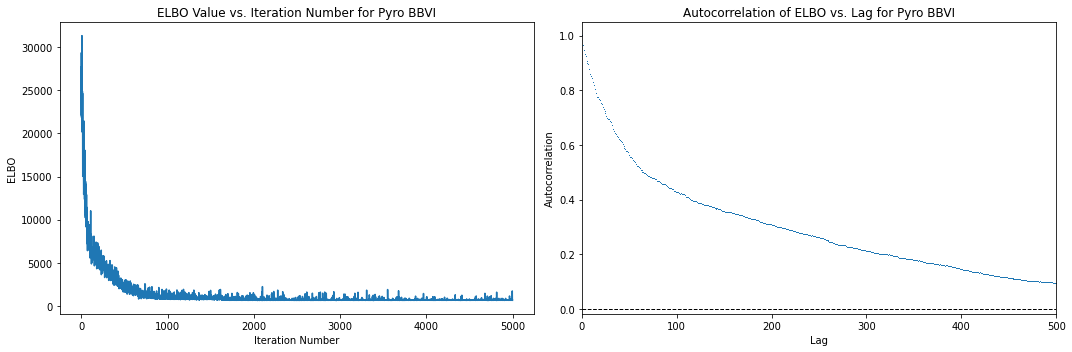

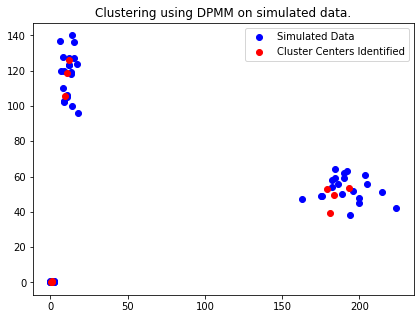

In [ ]:
# Try on test data
alpha = 10.0
dpplm_clust = DPPLMClust(data = test_data, num_clusters = 10, alpha = alpha, niter = 5000)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

Text(0.5, 1.0, 'Heatmap - Cluster Membership Probabilities')

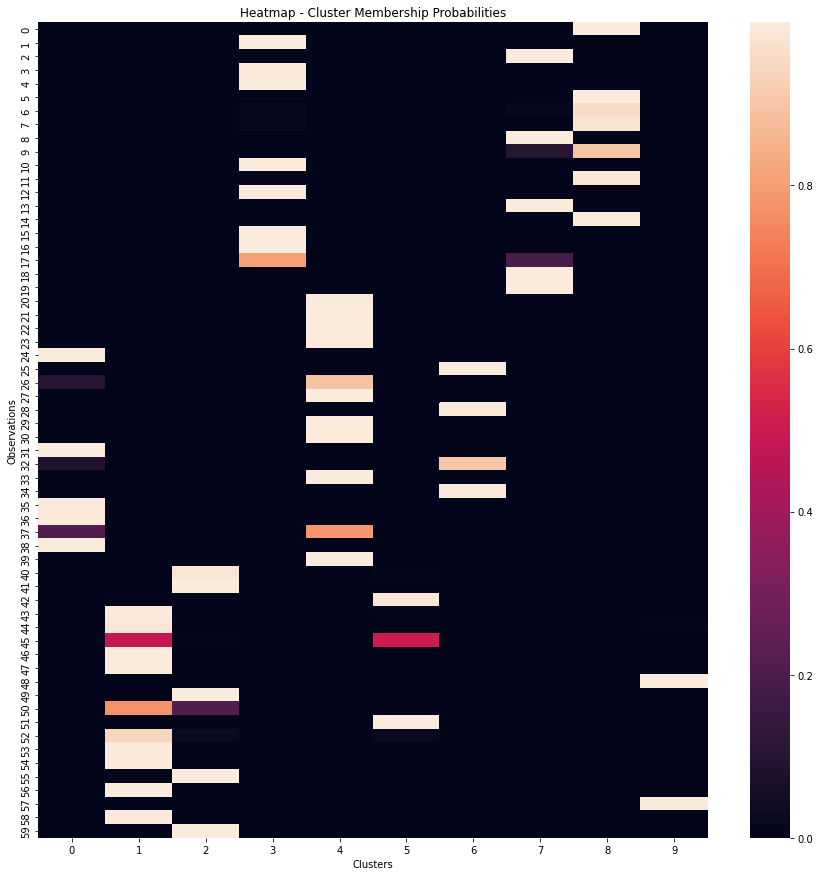

In [ ]:
# Cluster memberships
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")

Text(0.5, 1.0, 'Heatmap - Probability that 2 observations are in the same cluster')

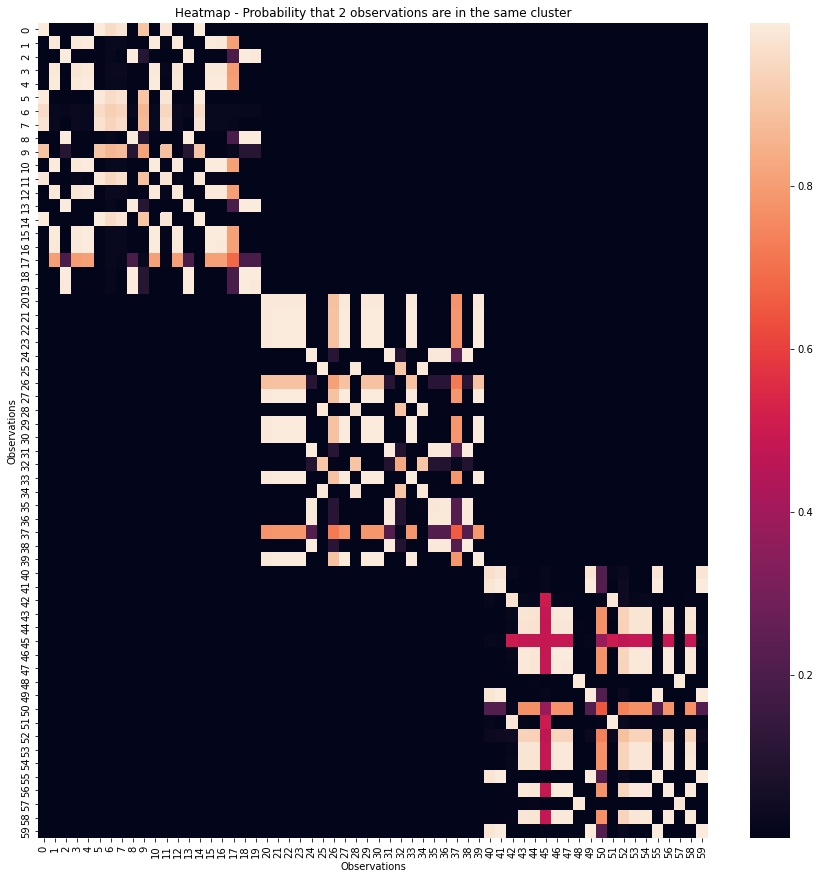

In [ ]:
# 2 observations are in the same cluster - visualize clustering of observations
pairwise = probs @ probs.T
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(pairwise)
axs.set_xlabel("Observations")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Probability that 2 observations are in the same cluster")

# Try data from Tara Chari et al 2021 paper

In [ ]:
#Read in previously saved data
bus_fs_clus = anndata.read("D1.1796")
print(bus_fs_clus )

bus_fs_raw = anndata.read("D1.1797")

bus_fs_raw = bus_fs_raw[bus_fs_clus.obs_names,]
bus_fs_raw.obs['fed'] = bus_fs_clus.obs['fed']
bus_fs_raw.obs['cellRanger_louvain'] = bus_fs_clus.obs['cellRanger_louvain']
bus_fs_raw


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 13673 × 8696
    obs: 'batch', 'n_counts', 'n_countslog', 'louvain', 'leiden', 'orgID', 'fed', 'starved', 'fed_neighbor_score', 'cellRanger_louvain', 'annos', 'new_cellRanger_louvain', 'annosSub'
    var: 'n_counts', 'mean', 'std'
    uns: 'annosSub_colors', 'annos_colors', 'cellRanger_louvain_colors', 'cellRanger_louvain_sizes', "dendrogram_['new_cellRanger_louvain']", 'dendrogram_new_cellRanger_louvain', 'fed_colors', 'fed_neighbor_score_colors', 'leiden', 'leiden_colors', 'louvain', 'louvain_colors', 'neighbors', 'new_cellRanger_louvain_colors', 'orgID_colors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_nca', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


AnnData object with n_obs × n_vars = 13673 × 46716
    obs: 'batch', 'fed', 'cellRanger_louvain'

In [ ]:
# Cluster DE Genes by Expression and Run TopGO Analysis
deGenesDF = pd.read_csv('D1.1810') #deSeq2_deGenesDF_log2FCof1_singleCellReplicates_noShrinkage_subSample_annotations.csv from DeSeq2 analysis
deGenesDF.head()


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Genes,Cluster,Condition,padj,padjClus,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms,geneClus
0,0,0,1,XLOC_028699,0,Starved,5.554489e-16,1.832981e-14,-1.284301,NaN,NaN,NaN,NaN,NaN,4
1,1,1,2,XLOC_010635,0,Starved,2.528288e-14,8.343350e-13,-1.492625,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4
2,2,2,3,XLOC_011294,0,Starved,8.348790e-14,2.755101e-12,-1.441413,NaN,NaN,NaN,NaN,[nan],0
3,3,3,4,XLOC_034889,0,Starved,1.786565e-13,5.895663e-12,-1.448216,NaN,NaN,['PTHR13680:SF29'],['CDGSH IRON-SULFUR DOMAIN-CONTAINING PROTEIN ...,[nan],1
4,4,4,5,XLOC_030861,0,Starved,8.598653e-12,2.837556e-10,-1.570453,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4


In [ ]:
deGenesDF_sig = deGenesDF[deGenesDF.padjClus < 0.05]


In [ ]:
#Filter raw count dataset for only perturbed genes
bus_fs_raw = anndata.read("D1.1797")
bus_fs_raw = bus_fs_raw [:,np.unique(deGenesDF_sig.Genes)]
bus_fs_raw =bus_fs_raw[bus_fs_clus.obs_names,:]
bus_fs_raw.obs['cellRanger_louvain'] = bus_fs_clus.obs['cellRanger_louvain']
bus_fs_raw.obs['fed'] = bus_fs_clus.obs['fed']


Trying to set attribute `.obs` of view, copying.


In [ ]:
de_gene_adata = anndata.AnnData(X=bus_fs_raw.X.T)
de_gene_adata.var_names = bus_fs_raw.obs_names
de_gene_adata.obs_names = bus_fs_raw.var_names

de_gene_adata_orig = de_gene_adata.copy()

numIntersects = deGenesDF['Genes'].value_counts()
num_intersect = []
for g in de_gene_adata.obs_names: 
    if g in list(deGenesDF['Genes']):
      num_intersect += [numIntersects[g]]
    else:
      num_intersect += [0]
    
de_gene_adata.obs['numIntersects'] = pd.Categorical(num_intersect)

de_gene_adata


AnnData object with n_obs × n_vars = 953 × 13673
    obs: 'numIntersects'

In [ ]:
data_chari = np.array(de_gene_adata.X.toarray(), dtype = int)
data_chari.shape


(953, 13673)

Text(0.5, 1.0, 'Mean vs Variance for Each gene across all samples')

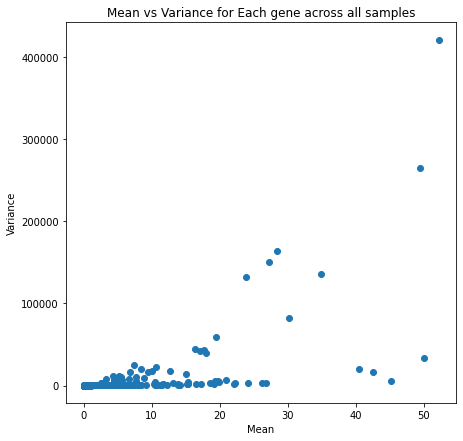

In [85]:
fig, axs = plt.subplots(figsize = (7, 7))
plt.scatter(data_chari.mean(axis = 1), data_chari.var(axis = 1))
plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Mean vs Variance for Each gene across all samples")


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


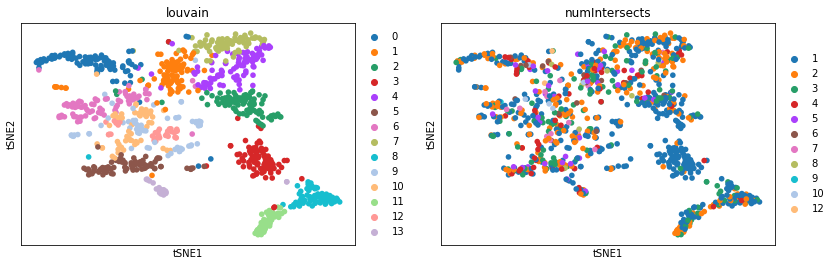

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


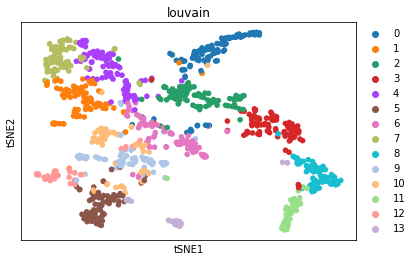

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Genes,Cluster,Condition,padj,padjClus,log2FC,orthoGene,orthoDescr,pantherID,pantherDescr,goTerms,geneClus
0,0,0,1,XLOC_028699,0,Starved,5.554489e-16,1.832981e-14,-1.284301,NaN,NaN,NaN,NaN,NaN,4
1,1,1,2,XLOC_010635,0,Starved,2.528288e-14,8.343350e-13,-1.492625,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4
2,2,2,3,XLOC_011294,0,Starved,8.348790e-14,2.755101e-12,-1.441413,NaN,NaN,NaN,NaN,[nan],0
3,3,3,4,XLOC_034889,0,Starved,1.786565e-13,5.895663e-12,-1.448216,NaN,NaN,['PTHR13680:SF29'],['CDGSH IRON-SULFUR DOMAIN-CONTAINING PROTEIN ...,[nan],1
4,4,4,5,XLOC_030861,0,Starved,8.598653e-12,2.837556e-10,-1.570453,SRSF1,serine/arginine-rich splicing factor 1 isofor...,['PTHR24012:SF650'],['SERINE/ARGININE-RICH SPLICING FACTOR 1'],[nan],4


In [ ]:
# More processing from their paper to get the gene modules identified in the paper.
# Will use this for comparing to our approach
#Normalize and scale data
scanpy.pp.filter_genes(de_gene_adata, min_counts=0)

scanpy.pp.normalize_per_cell(de_gene_adata, counts_per_cell_after=1e4)
de_gene_adata.raw = scanpy.pp.log1p(de_gene_adata, copy=True)

scanpy.pp.scale(de_gene_adata, max_value=10)
scanpy.tl.pca(de_gene_adata, n_comps=60,random_state=42)

#Determine neighbors for clustering
scanpy.pp.neighbors(de_gene_adata,n_neighbors=20, n_pcs=15)
scanpy.tl.louvain(de_gene_adata,resolution=2)

scanpy.tl.tsne(de_gene_adata, n_pcs=15,random_state=42)
scanpy.pl.tsne(de_gene_adata,color=['louvain','numIntersects'])

scanpy.tl.tsne(de_gene_adata, n_pcs=10,random_state=42,perplexity=15) #
scanpy.pl.tsne(de_gene_adata,color=['louvain'])

# Add which gene modules the pertubed genes are in
clusters = []
for g in deGenesDF.Genes:
  if g in list(de_gene_adata.obs_names):
    clus = de_gene_adata[g,:].obs['louvain'][0]
    clusters += [clus]
  else:
    clusters += ['padjClus_not_sig']

deGenesDF['geneClus'] = clusters
deGenesDF.head()

In [ ]:
collections.Counter(clusters)

Counter({'0': 244,
         '1': 264,
         '10': 155,
         '11': 85,
         '12': 81,
         '13': 52,
         '2': 157,
         '3': 95,
         '4': 207,
         '5': 205,
         '6': 195,
         '7': 115,
         '8': 114,
         '9': 133,
         'padjClus_not_sig': 1007})

In [ ]:
# Finally run our model
# subset data to 1500 cells because otherwise it is not tractable.
# Also using different kind of optimizer
rand_cell_idx = np.random.choice(data_chari.shape[1], 1500)
data_chari_sampled = data_chari[:, rand_cell_idx]
data_chari_sampled.shape

(953, 1500)

100%|██████████| 5000/5000 [05:09<00:00, 16.18it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:2021: RuntimeWarning: overflow encountered in double_scalars
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))


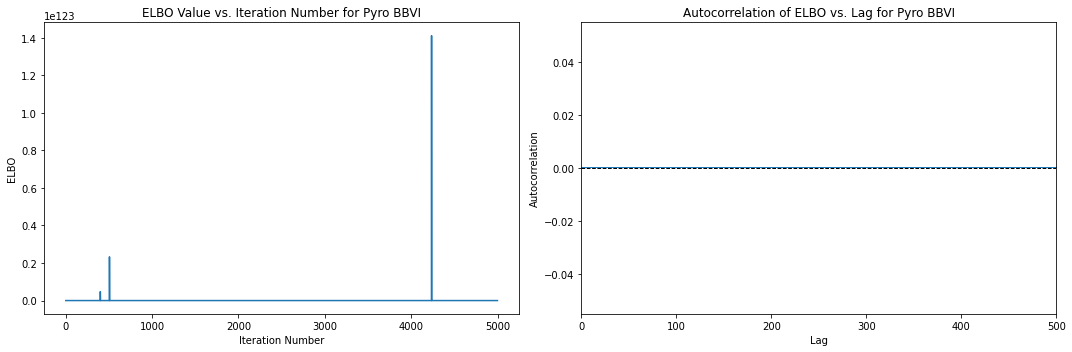

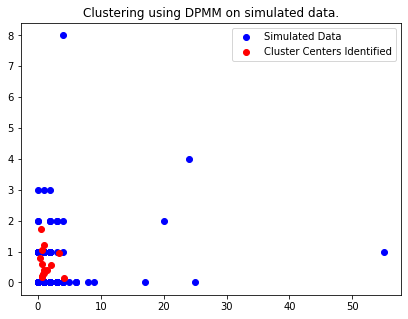

In [ ]:
# 14 clusters were identified in the paper
num_clusters = 14
alpha = 10.0
niter = 5000

# use a more flexible optimizer for numerical stability
initial_lr = 0.001
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / niter)
optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

dpplm_clust = DPPLMClust(data = torch.tensor(data_chari_sampled), num_clusters = num_clusters, alpha = alpha, niter = niter, optim = optim)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

Text(0.5, 1.0, 'Heatmap - Cluster Membership Probabilities')

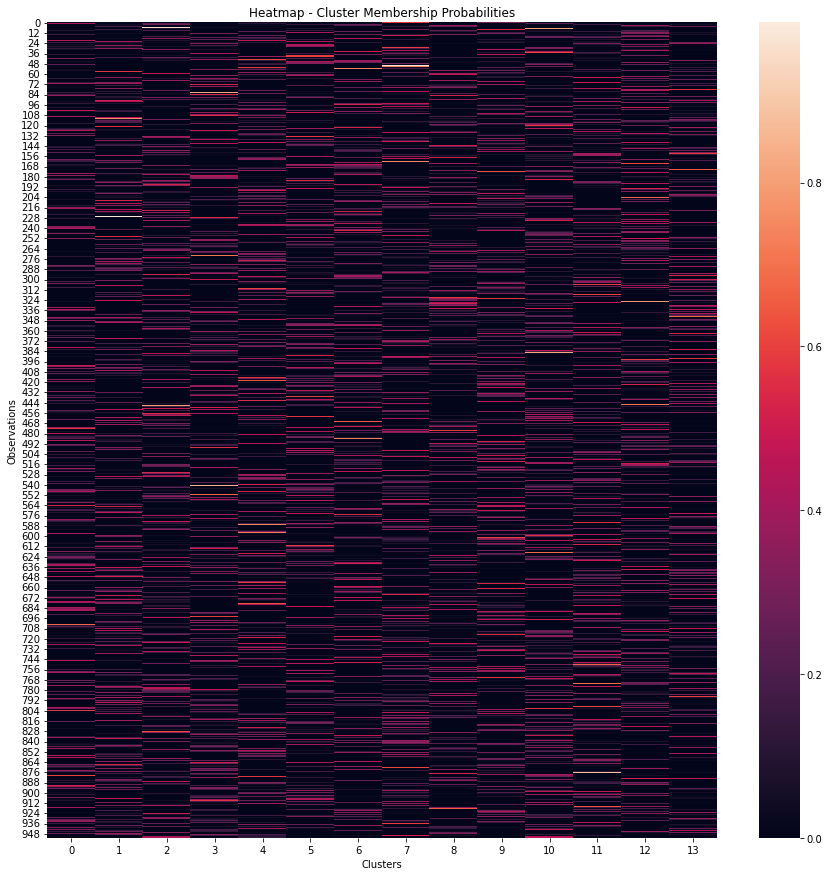

In [ ]:
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")

In [ ]:
clusters = collections.defaultdict(list)
i = 0
for g in de_gene_adata:
  clusters[g.obs["louvain"][0]].append(list(probs[i]))
  i += 1
cluster_sorted_probs = []
for cluster in sorted(clusters.keys()):
  cluster_sorted_probs.extend(clusters[cluster])

cluster_memberships_paper = collections.defaultdict(list)
cluster_memberships_mine = collections.defaultdict(list)
i = 0
cluster_labels_paper = []
cluster_labels_mine = []
for g in de_gene_adata:
  cluster_memberships_paper[g.obs["louvain"][0]].append(i)
  cluster_memberships_mine[np.argmax(probs[i])].append(i)
  cluster_labels_paper.append(int(g.obs["louvain"][0]))
  cluster_labels_mine.append(np.argmax(probs[i]))
  i += 1


In [ ]:
metrics.adjusted_rand_score(cluster_labels_paper, cluster_labels_mine)

0.0012466711022856957

  0%|          | 0/12000 [00:00<?, ?it/s]

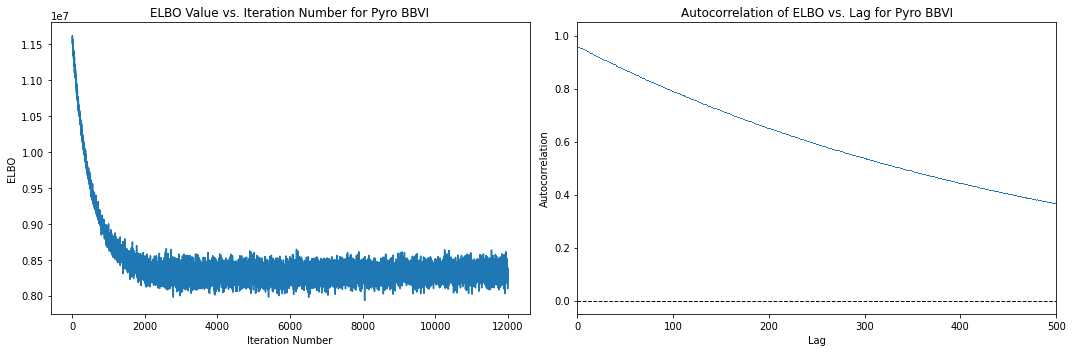

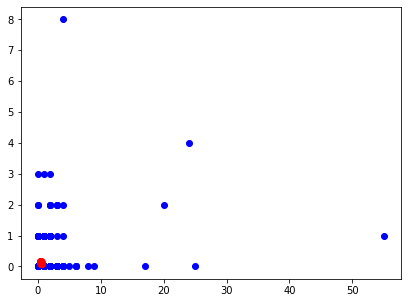

In [86]:
## Try GammaPoisson
# 14 clusters were identified in the paper
num_clusters = 14
alpha = 10.0
niter = 12000

# use a more flexible optimizer for numerical stability
initial_lr = 0.001
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / niter)
optim = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

dpplm_clust = DPPMClust(data = torch.tensor(data_chari_sampled), num_clusters = num_clusters, alpha = alpha, niter = niter, optim = optim)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

-0.0004548099549643921

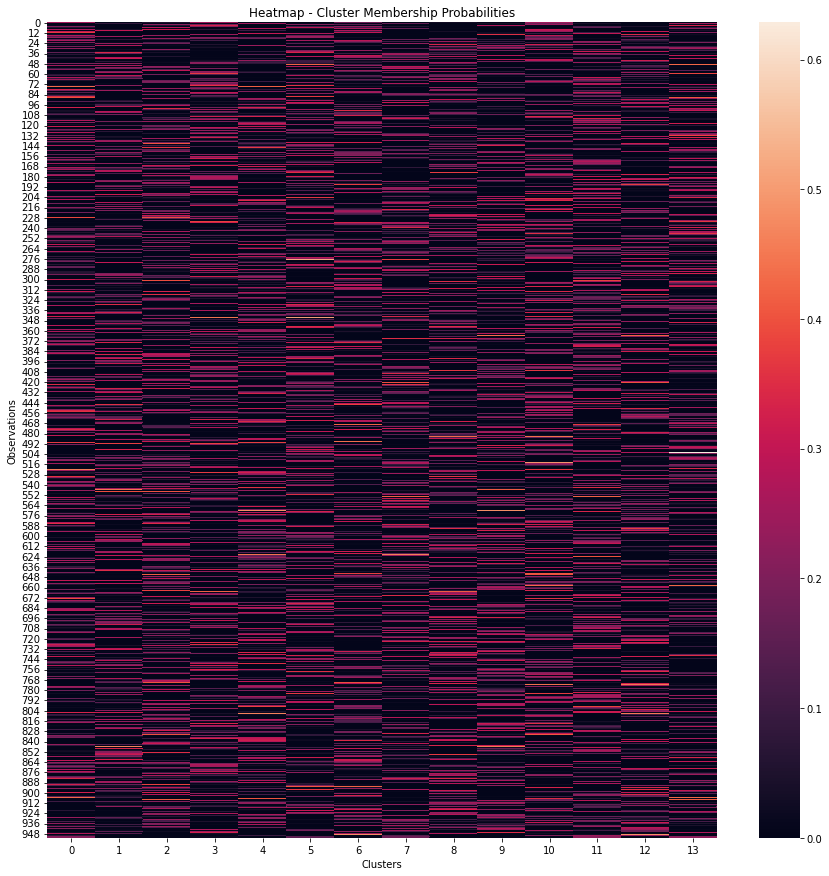

In [87]:
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")

clusters = collections.defaultdict(list)
i = 0
for g in de_gene_adata:
  clusters[g.obs["louvain"][0]].append(list(probs[i]))
  i += 1
cluster_sorted_probs = []
for cluster in sorted(clusters.keys()):
  cluster_sorted_probs.extend(clusters[cluster])

cluster_memberships_paper = collections.defaultdict(list)
cluster_memberships_mine = collections.defaultdict(list)
i = 0
cluster_labels_paper = []
cluster_labels_mine = []
for g in de_gene_adata:
  cluster_memberships_paper[g.obs["louvain"][0]].append(i)
  cluster_memberships_mine[np.argmax(probs[i])].append(i)
  cluster_labels_paper.append(int(g.obs["louvain"][0]))
  cluster_labels_mine.append(np.argmax(probs[i]))
  i += 1

metrics.adjusted_rand_score(cluster_labels_paper, cluster_labels_mine)


## Geuvadis Dataset

Text(0.5, 1.0, 'Mean vs Variance for Each gene across all samples')

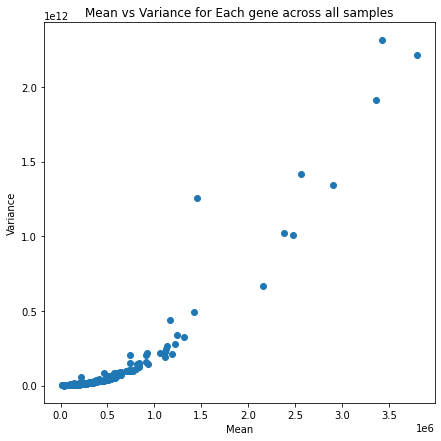

In [80]:
fig, axs = plt.subplots(figsize = (7, 7))
plt.scatter(data_geuvadis.mean(axis = 1), data_geuvadis.var(axis = 1))


plt.xlabel("Mean")
plt.ylabel("Variance")
plt.title("Mean vs Variance for Each gene across all samples")


100%|██████████| 5000/5000 [01:49<00:00, 45.83it/s]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:2021: RuntimeWarning: overflow encountered in double_scalars
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))


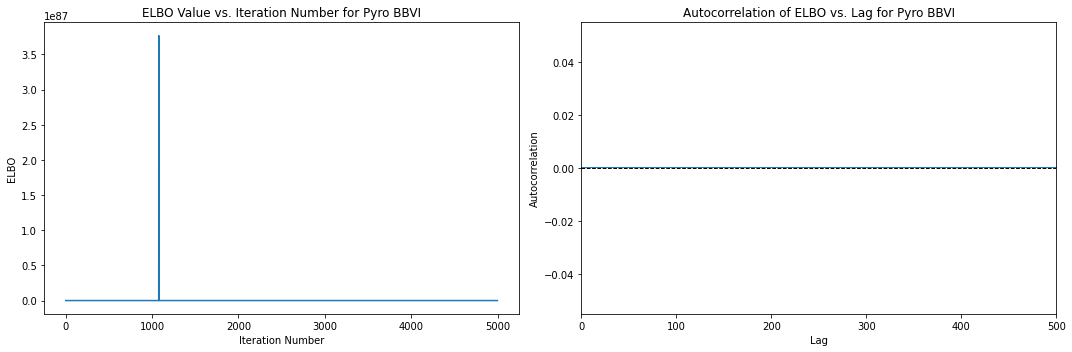

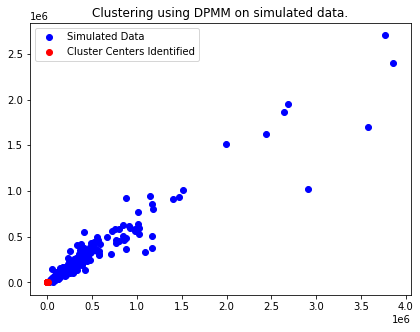

In [ ]:
alpha = 10.0
num_clusters = 8

dpplm_clust = DPPLMClust(data = torch.tensor(data_geuvadis), num_clusters = num_clusters, alpha = alpha, niter = niter, optim = optim)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

  0%|          | 0/10000 [00:00<?, ?it/s]

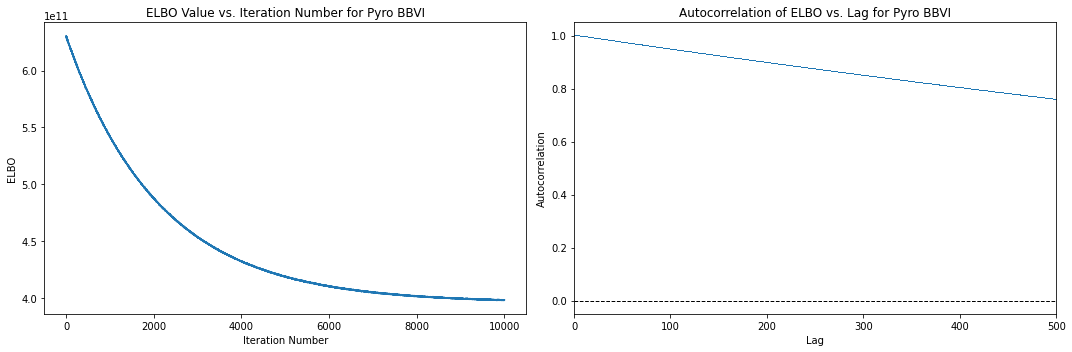

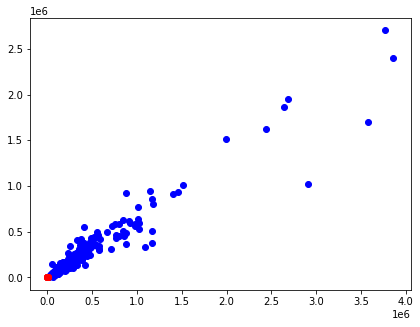

In [ ]:
alpha = 10.0
num_clusters = 8
niter = 10000

dpplm_clust = DPPMClust(data = torch.tensor(data_geuvadis), num_clusters = num_clusters, alpha = alpha, niter = niter, optim = optim)  
dpplm_clust.var_inference()
# Visualize
dpplm_clust.loss_viz()
dpplm_clust.cluster_2d_viz()

Text(0.5, 1.0, 'Heatmap - Cluster Membership Probabilities')

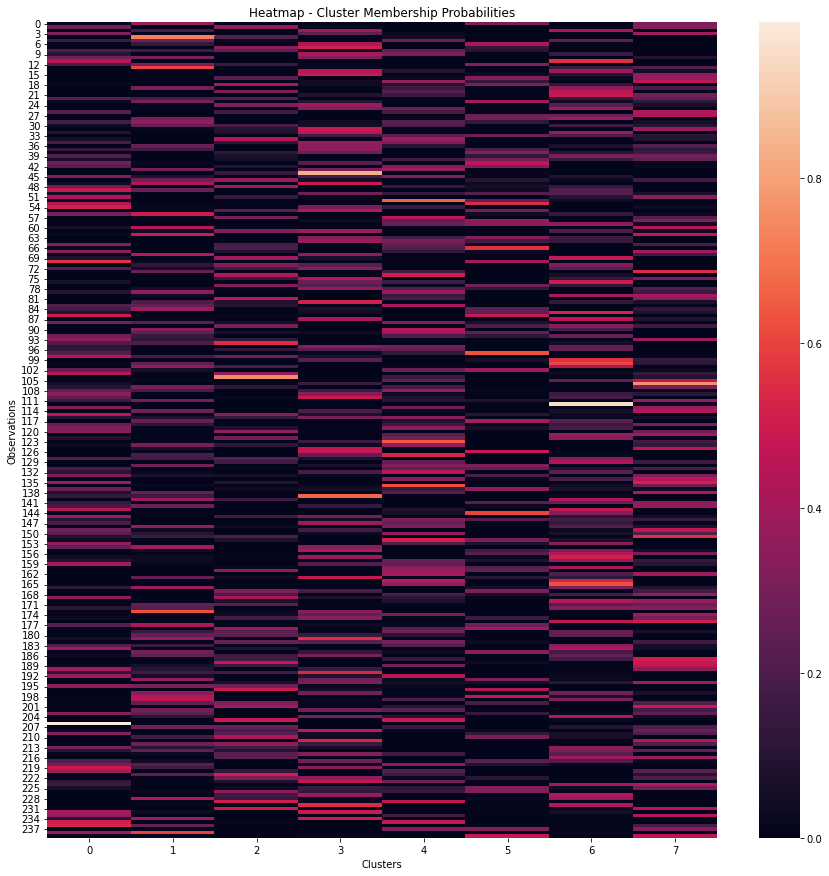

In [ ]:
probs = pyro.param("phi").detach().cpu().numpy()
fig, axs = plt.subplots(figsize = (15, 15))
sns.heatmap(probs)
axs.set_xlabel("Clusters")
axs.set_ylabel("Observations")
axs.set_title("Heatmap - Cluster Membership Probabilities")


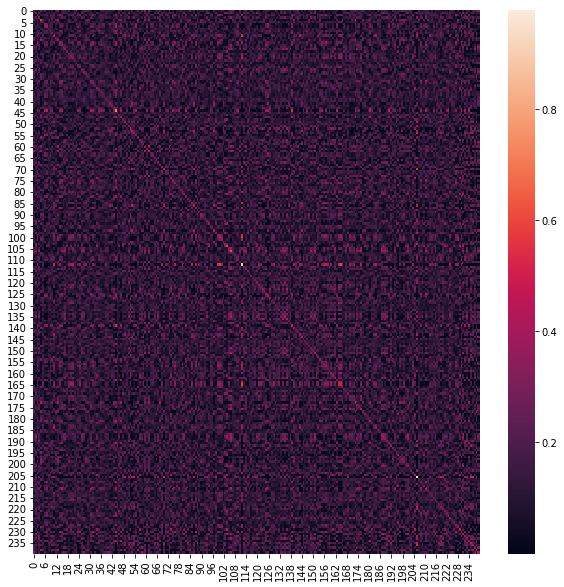

In [ ]:
fig, axs = plt.subplots(figsize = (10, 10))
pairwise = np.array(probs) @ np.array(probs).T
sns.heatmap(pairwise)

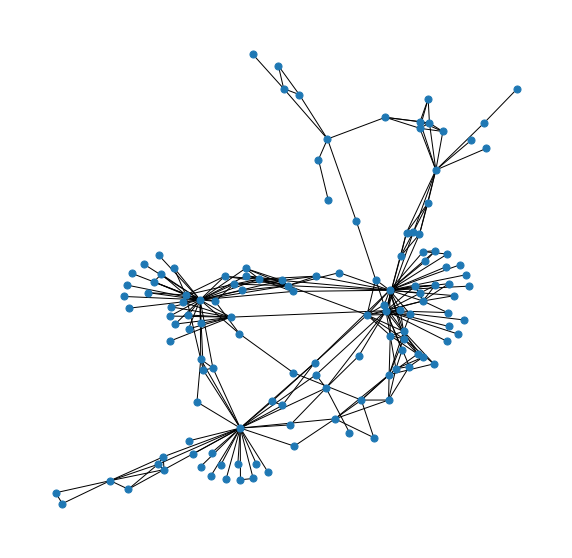

In [ ]:
# network diagram
G = nx.Graph()
i = 0
for i in range(0, pairwise.shape[0]):
    for j in range(0, pairwise.shape[1]):
        if i != j:
            if pairwise[i][j] >= 0.35:
                G.add_edge(i, j)
fig,axs = plt.subplots(figsize = (10, 10))
nx.draw(G, with_labels=False, node_size = 50)


In [ ]:
# high degree genes
degrees = {node:val for (node, val) in G.degree()}
sorted_genes = [e1 for e1, e2 in sorted(degrees.items(), key=lambda x:x[1], reverse = True)]
print(sorted(degrees.items(), key=lambda x:x[1], reverse = True)[0:10])
orig_df.iloc[sorted_genes[0:10]]["gene_symbol"]

[(112, 33), (44, 28), (206, 27), (106, 21), (230, 13), (104, 11), (139, 11), (165, 10), (176, 10), (181, 10)]


112     HSD17B4
44         CRYM
206      MRPL14
106         RAN
230      INPP5B
104      MRPL35
139      TXNL4A
165        PTMS
176         SYK
181    TMEM194A
Name: gene_symbol, dtype: object

In [ ]:
data_geuvadis.shape

(240, 504)